In [2]:
import numpy as np
import pandas as pd
import datetime, time
from datetime import date, timedelta
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'
store_file = 'data/store.csv'

In [4]:
store = pd.read_csv(store_file)

In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We can see that there are some `null` values in the datasets, let's see what are these? And how we can fill these `null` values?
* "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" these 2 columns are filled with the earlist dates, because only with this we can assume that there are minimum competition with `null` values
* "CompetitionDistance" are filled with the maximum value, assuming that we can minimum influence as above

In [7]:
store.fillna(store.min()['CompetitionOpenSinceMonth':'CompetitionOpenSinceYear'], inplace=True)

In [8]:
store = store.fillna(store.max()['CompetitionDistance':'CompetitionDistance'])

In [9]:
store.fillna(0, inplace=True)  # fill others' null with 0

In [10]:
x = store['CompetitionDistance']
x.count()

1115

In [11]:
store.count()

Store                        1115
StoreType                    1115
Assortment                   1115
CompetitionDistance          1115
CompetitionOpenSinceMonth    1115
CompetitionOpenSinceYear     1115
Promo2                       1115
Promo2SinceWeek              1115
Promo2SinceYear              1115
PromoInterval                1115
dtype: int64

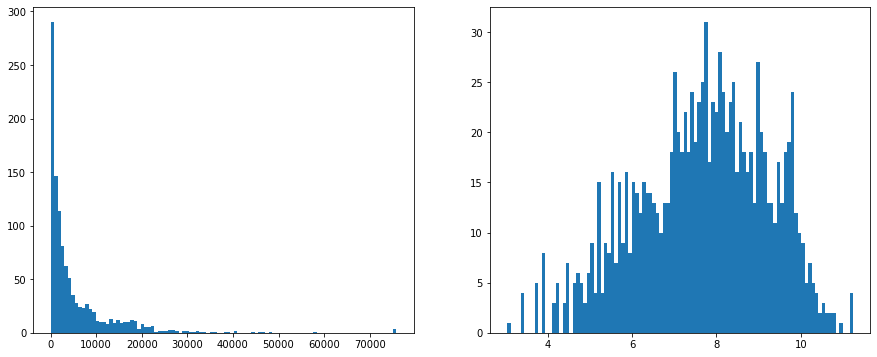

In [12]:
x = store['CompetitionDistance']
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(x, 100)

plt.subplot(122)
plt.hist(np.log1p(x), 100)  
# log(x + 1)  
# https://stackoverflow.com/questions/49538185/what-is-the-purpose-of-numpy-log1p/49538384
plt.show()

In [13]:
store['StoreType'] = store['StoreType'].map({'a':0, 'b':1, 'c':2, 'd':3})
store['Assortment'] = store['Assortment'].map({'a':0, 'b':1, 'c':2, 'd':3})

In [14]:
store['CompetitionOpenSinceYear'].sort_values().unique()

array([1900., 1961., 1990., 1994., 1995., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015.])

In [15]:
store['CompetitionOpenSinceMonth'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [16]:
from datetime import date, timedelta

def get_competition_open_day(row):
    openyear = int(row['CompetitionOpenSinceYear'])
    if openyear < 2000:
        openyear = 2000  #再早的年份也没有意义了
    openmonth = int(row['CompetitionOpenSinceMonth'])
    open_day = date(openyear, openmonth, 1)

    base_day = date(2000,1,1) #base day is 2000-1-1
    
    return (open_day - base_day).days  # get days date

`OpenedDays` means how many days that the competition has been opened since 2000,1,1

In [17]:
store['OpenedDays'] = store.apply(get_competition_open_day, axis=1)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,OpenedDays
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,3166
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2861
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2526
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0,3531
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0,5569


In [45]:
month_dict = {'Jan':1,'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8,'Sept':9,'Oct':10, 'Nov':11, 'Dec':12}

In [46]:
store['PromoInterval'].unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [18]:
interval_list = store['PromoInterval'].values.tolist()
interval_list

[0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 'Feb,May,Aug,Nov',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 'Mar,Jun,Sept,Dec',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 'Jan,Apr,Jul,Oct',
 0,
 0,
 'Jan,Apr,Jul,Oct',
 'Mar,Jun,Sept,Dec',
 0,
 'Mar,Jun,Sept,Dec',
 0,
 'Feb,May,Aug,Nov',
 0,
 0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 0,
 'Feb,May,Aug,Nov',
 'Feb,May,Aug,Nov',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 0,
 0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 'Feb,May,Aug,Nov',
 0,
 'Mar,Jun,Sept,Dec',
 0,
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 'Jan,Apr,Jul,Oct',
 0,
 'Feb,May,Aug,Nov',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 'Jan,Apr,Jul,Oct',
 0,
 'Mar,Jun,Sept,Dec',
 'Jan,Apr,Jul,Oct',
 0,
 'Mar,Jun,Sept,Dec',
 'Jan,Apr,Jul,Oct',
 0,
 0,
 0,
 0,
 'Jan,Apr,Jul,Oct'

In [20]:
for key, item in enumerate(interval_list):
    if item != 0:
        if len(item.split(',')) != 4:
            print (key,item)
# all value except 0 are with 4 diff. months

In [21]:
# one example
store['PromoInterval'].iloc[2]  
row = store.iloc[2]
row['PromoInterval'].split(',')

['Jan', 'Apr', 'Jul', 'Oct']

In [22]:
def change_to_intervals(row):
    interval1 = interval2 = interval3 =interval4 = 0
    if row['Promo2'] != 0:
        months = row['PromoInterval'].split(',')
        interval1 = month_dict[months[0]]
        interval2 = month_dict[months[1]]
        interval3 = month_dict[months[2]]
        interval4 = month_dict[months[3]]
        
    return interval1, interval2, interval3, interval4

Change the columns `PromoInterval` to `four` diff. numbers representing the month

In [51]:
store['Interval1'] = np.nan
store['Interval2'] = np.nan
store['Interval3'] = np.nan
store['Interval4'] = np.nan

store['Interval1'], store['Interval2'], store['Interval3'], store['Interval4'] = zip(*store.apply(change_to_intervals,axis=1))
# store = store.drop('PromoInterval', axis=1)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,OpenedDays,Interval1,Interval2,Interval3,Interval4
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,3166,0,0,0,0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2861,1,4,7,10
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2526,1,4,7,10
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0,3531,0,0,0,0
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0,5569,0,0,0,0


In [23]:
store['Promo2SinceYear'].unique()

array([   0., 2010., 2011., 2012., 2009., 2014., 2015., 2013.])

In [24]:
import datetime, time

def convert_promo2_startday(row):
    if row['Promo2'] == 0:
        promo2_day = -1
    else:
        weekofyear_string = '%d-W%d'%(row['Promo2SinceYear'],row['Promo2SinceWeek'])
        day_time = datetime.datetime.strptime(weekofyear_string + '-0', "%Y-W%U-%w")
        promo2_open_day = date(day_time.year, day_time.month, day_time.day)
        base_day = date(2000,1,1)
        
        promo2_day = (promo2_open_day - base_day).days
    return promo2_day

In [26]:
# “Promo2Days” indicates how many days have been there since the promo2 started
store['Promo2Days'] = store.apply(convert_promo2_startday,axis=1)
#store = store.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis =1)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,OpenedDays,Promo2Days
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,3166,-1
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2861,3739
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2526,4110
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0,3531,-1
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0,5569,-1


In [27]:
train = pd.read_csv(train_file, parse_dates=True)

/home/tianran/anaconda3/envs/MLND/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [29]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [30]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [31]:
train['SchoolHoliday'].unique()

array([1, 0])

In [32]:
train['StateHoliday'] = train['StateHoliday'].astype(str)
train['StateHoliday'] = train['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3})

In [33]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [34]:
train['Date']= pd.to_datetime(train['Date'])
train = train.sort_values('Date')

In [35]:
def get_current_day(row):
    tmp = row['Date']
    today = date(tmp.year, tmp.month, tmp.day)
    base_day = date(2000,1,1)
    return (today - base_day).days

In [37]:
train['cnt_days'] = train.apply(get_current_day,axis=1)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Currentday,cnt_days
1017208,1115,2,2013-01-01,0,0,0,0,1,1,4749,4749
1016473,379,2,2013-01-01,0,0,0,0,1,1,4749,4749
1016472,378,2,2013-01-01,0,0,0,0,1,1,4749,4749
1016471,377,2,2013-01-01,0,0,0,0,1,1,4749,4749
1016470,376,2,2013-01-01,0,0,0,0,1,1,4749,4749


In [38]:
train['Year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
train['Day'] = train['Date'].apply(lambda x: x.day)
train['WeekofYear'] = train['Date'].apply(lambda x: x.week)
train['DayofYear'] = train['Date'].apply(lambda x: x.dayofyear)
#train = train.drop(['Date'], axis=1)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Currentday,cnt_days,Year,Month,Day,WeekofYear,DayofYear
1017208,1115,2,2013-01-01,0,0,0,0,1,1,4749,4749,2013,1,1,1,1
1016473,379,2,2013-01-01,0,0,0,0,1,1,4749,4749,2013,1,1,1,1
1016472,378,2,2013-01-01,0,0,0,0,1,1,4749,4749,2013,1,1,1,1
1016471,377,2,2013-01-01,0,0,0,0,1,1,4749,4749,2013,1,1,1,1
1016470,376,2,2013-01-01,0,0,0,0,1,1,4749,4749,2013,1,1,1,1
